In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
%matplotlib inline

In [3]:
dataset = pd.read_excel('data.xlsx')
regression_dataset = dataset.copy()[["T","Tn","Tx","datetime"]].sort_values("datetime")
tempure_data = regression_dataset[["T","Tn","Tx"]].values.astype(float)

In [4]:
scaler = MinMaxScaler()
tempure_data_scaled = scaler.fit_transform(tempure_data)

In [5]:
class TemperatureDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, idx):
        inputs = self.data[idx:idx+self.seq_length]
        target = self.data[idx+self.seq_length][0]  # 预测下一个时间点的温度T
        inputs = torch.tensor(inputs, dtype=torch.float32)
        target = torch.tensor(target, dtype=torch.float32)
        return inputs, target

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # 初始化 hidden state 和 cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # 前向传播 LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # 将 LSTM 的输出输入到全连接层
        out = self.fc(out[:, -1, :])
        return out

In [7]:
seq_length = 20
input_size = 3  # T, Tn, Tx
hidden_size = 64
num_layers = 2
output_size = 1
learning_rate = 0.001
batch_size = 64
num_epochs = 50

In [8]:
train_size = int(len(tempure_data_scaled) * 0.8)
train_data = tempure_data_scaled[:train_size]
test_data = tempure_data_scaled[train_size:]

train_dataset = TemperatureDataset(train_data, seq_length)
test_dataset = TemperatureDataset(test_data, seq_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
model.train()
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader),total = len(train_loader))
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)

        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loop.set_description(f'Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())

print("Finished Training")

Epoch [50/50]: 100%|██████████| 182/182 [00:01<00:00, 107.21it/s, loss=0.00118] 

Finished Training


In [11]:
model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        test_loss += loss.item()

test_loss /= len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Loss: 0.0009


In [12]:
def predict(model, data, seq_length, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(data) - seq_length):
            inputs = data[i:i+seq_length]
            inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)  # 添加 batch 维度
            output = model(inputs)
            predictions.append(output.item())
    return predictions


In [13]:
test_input = tempure_data_scaled[train_size-seq_length:]
# 进行预测
predicted_values = predict(model, test_input, seq_length, device)

# 反归一化
predicted_values = np.array(predicted_values).reshape(-1, 1)
predicted_values = scaler.inverse_transform(np.concatenate([predicted_values, np.zeros_like(predicted_values), np.zeros_like(predicted_values)], axis=1))[:, 0]

# 真实值
real_values = regression_dataset["T"].values[train_size+seq_length:]

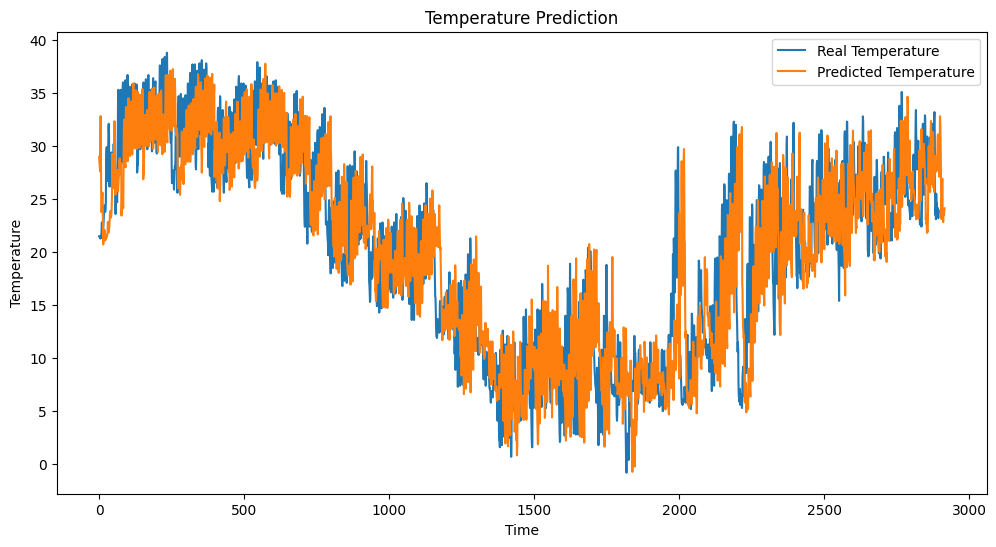

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(real_values, label='Real Temperature')
plt.plot(predicted_values, label='Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Prediction')
plt.legend()
plt.show()

In [15]:
# 裁剪 predicted_values 和 real_values 到相同的长度
min_length = min(len(predicted_values), len(real_values))
predicted_values = predicted_values[:min_length]
real_values = real_values[:min_length]

# 计算相对百分误差
relative_percentage_error = np.mean(np.abs((predicted_values - real_values) / real_values)) * 100
print("Relative Percentage Error (RPE): {:.2f}%".format(relative_percentage_error))

# 打印一部分预测结果和实际结果进行对比
num_samples_to_print = 20  # 可以调整这个值来显示更多或更少的样本
print("Predictions vs Real Values (First {} samples):".format(num_samples_to_print))
for i in range(num_samples_to_print):
    error = abs((predicted_values[i] - real_values[i]) / real_values[i]) * 100
    print("Predicted: {:.2f}, Real: {:.2f}, Error: {:.2f}%".format(predicted_values[i], real_values[i], error))

Relative Percentage Error (RPE): 35.37%
Predictions vs Real Values (First 20 samples):
Predicted: 28.99, Real: 21.50, Error: 34.84%
Predicted: 28.42, Real: 21.50, Error: 32.21%
Predicted: 28.12, Real: 21.50, Error: 30.81%
Predicted: 27.60, Real: 21.30, Error: 29.57%
Predicted: 30.90, Real: 21.40, Error: 44.38%
Predicted: 32.82, Real: 21.30, Error: 54.11%
Predicted: 28.91, Real: 21.30, Error: 35.71%
Predicted: 25.28, Real: 21.60, Error: 17.02%
Predicted: 23.77, Real: 21.80, Error: 9.05%
Predicted: 24.13, Real: 22.80, Error: 5.83%
Predicted: 25.28, Real: 22.70, Error: 11.39%
Predicted: 25.61, Real: 22.40, Error: 14.33%
Predicted: 25.58, Real: 22.10, Error: 15.76%
Predicted: 22.18, Real: 22.20, Error: 0.07%
Predicted: 20.71, Real: 22.20, Error: 6.69%
Predicted: 21.05, Real: 22.70, Error: 7.27%
Predicted: 21.24, Real: 23.40, Error: 9.22%
Predicted: 21.62, Real: 24.00, Error: 9.93%
Predicted: 22.12, Real: 24.40, Error: 9.36%
Predicted: 21.56, Real: 24.10, Error: 10.54%


In [16]:
def predict_future_days(model, data, seq_length, predict_days, device, scaler):
    """
    递归预测未来多天的气温
    :param model: 已训练好的模型
    :param data: 已归一化的历史数据（二维数组）
    :param seq_length: 输入序列长度
    :param predict_days: 需要预测的天数
    :param device: 设备
    :param scaler: 用于反归一化
    :return: 预测的未来气温（已反归一化）
    """
    model.eval()
    input_seq = data[-seq_length:].copy()  # 最近 seq_length 天的数据
    predictions = []
    with torch.no_grad():
        for _ in range(predict_days):
            inp = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            out = model(inp)
            pred_t = out.item()
            # 构造下一个输入（假设Tn、Tx未知，用前一天的Tn、Tx或0填充）
            next_input = np.array([pred_t, input_seq[-1][1], input_seq[-1][2]])
            input_seq = np.vstack([input_seq[1:], next_input])
            predictions.append(next_input)
    # 反归一化
    predictions = np.array(predictions)
    predictions_inv = scaler.inverse_transform(predictions)[:, 0]  # 只取T
    return predictions_inv

# 用法示例（假设预测未来7天）：
future_days = 7
future_predictions = predict_future_days(model, tempure_data_scaled, seq_length, future_days, device, scaler)
print("未来7天预测气温：", future_predictions)

未来7天预测气温： [24.10558803 23.7061928  23.1464587  22.76283808 22.62319754 22.84877391
 23.39280601]


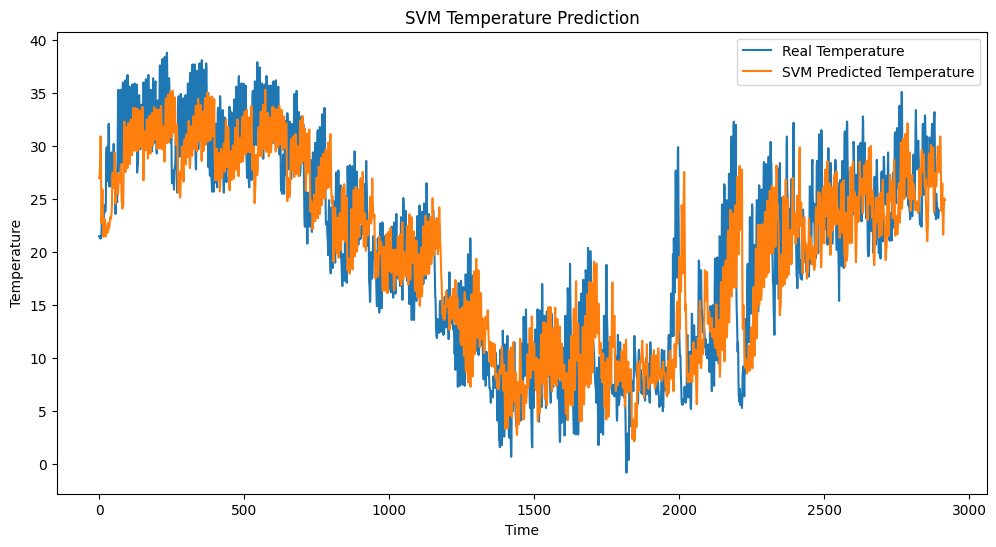

SVM Relative Percentage Error (RPE): 34.25%


In [17]:
from sklearn.svm import SVR

# 构造特征和标签
# 这里用与LSTM相同的滑动窗口方式，便于对比
def create_svm_dataset(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length].flatten())
        y.append(data[i+seq_length][0])  # 预测T
    return np.array(X), np.array(y)

svm_seq_length = 20  # 与LSTM保持一致
X, y = create_svm_dataset(tempure_data_scaled, svm_seq_length)

# 划分训练集和测试集
X_train, X_test = X[:train_size-svm_seq_length], X[train_size-svm_seq_length:]
y_train, y_test = y[:train_size-svm_seq_length], y[train_size-svm_seq_length:]

# 训练SVM回归模型
svm_model = SVR(kernel='rbf')
svm_model.fit(X_train, y_train)

# 预测
svm_pred_scaled = svm_model.predict(X_test)

# 反归一化
svm_pred_scaled = svm_pred_scaled.reshape(-1, 1)
svm_pred_full = np.concatenate([svm_pred_scaled, np.zeros_like(svm_pred_scaled), np.zeros_like(svm_pred_scaled)], axis=1)
svm_pred = scaler.inverse_transform(svm_pred_full)[:, 0]

# 真实值
svm_real = regression_dataset["T"].values[train_size+svm_seq_length:]

# 可视化
plt.figure(figsize=(12, 6))
plt.plot(svm_real, label='Real Temperature')
plt.plot(svm_pred, label='SVM Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('SVM Temperature Prediction')
plt.legend()
plt.show()

# 计算误差
svm_min_length = min(len(svm_pred), len(svm_real))
svm_pred = svm_pred[:svm_min_length]
svm_real = svm_real[:svm_min_length]
svm_rpe = np.mean(np.abs((svm_pred - svm_real) / svm_real)) * 100
print("SVM Relative Percentage Error (RPE): {:.2f}%".format(svm_rpe))

In [18]:
import torch.nn.functional as F

class TransformerRegressor(nn.Module):
    def __init__(self, input_size, d_model=64, nhead=4, num_layers=2, output_size=1, dim_feedforward=128, dropout=0.1):
        super(TransformerRegressor, self).__init__()
        self.input_linear = nn.Linear(input_size, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        # x: (batch, seq_len, input_size)
        x = self.input_linear(x)
        x = self.transformer_encoder(x)
        out = self.fc(x[:, -1, :])  # 取最后一个时间步
        return out

In [19]:
# 参数设置
transformer_d_model = 64
transformer_nhead = 4
transformer_num_layers = 2
transformer_dim_feedforward = 128
transformer_dropout = 0.1

# 实例化模型
transformer_model = TransformerRegressor(
    input_size=input_size,
    d_model=transformer_d_model,
    nhead=transformer_nhead,
    num_layers=transformer_num_layers,
    output_size=output_size,
    dim_feedforward=transformer_dim_feedforward,
    dropout=transformer_dropout
).to(device)

transformer_criterion = nn.MSELoss()
transformer_optimizer = optim.Adam(transformer_model.parameters(), lr=learning_rate)

In [20]:
# 训练
transformer_model.train()
for epoch in range(num_epochs):
    loop = tqdm(enumerate(train_loader), total=len(train_loader))
    for batch_idx, (inputs, targets) in loop:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = transformer_model(inputs)
        loss = transformer_criterion(outputs.squeeze(), targets)
        transformer_optimizer.zero_grad()
        loss.backward()
        transformer_optimizer.step()
        loop.set_description(f'Transformer Epoch [{epoch+1}/{num_epochs}]')
        loop.set_postfix(loss=loss.item())
print("Transformer Finished Training")


Transformer Epoch [50/50]: 100%|██████████| 182/182 [00:05<00:00, 35.69it/s, loss=0.00149] 

Transformer Finished Training


In [21]:
# 测试
transformer_model.eval()
test_loss = 0.0
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = transformer_model(inputs)
        loss = transformer_criterion(outputs.squeeze(), targets)
        test_loss += loss.item()
test_loss /= len(test_loader)
print(f"Transformer Test Loss: {test_loss:.4f}")

Transformer Test Loss: 0.0017


In [22]:
# 预测
def transformer_predict(model, data, seq_length, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(len(data) - seq_length):
            inputs = data[i:i+seq_length]
            inputs = torch.tensor(inputs, dtype=torch.float32).unsqueeze(0).to(device)
            output = model(inputs)
            predictions.append(output.item())
    return predictions

In [23]:
test_input = tempure_data_scaled[train_size-seq_length:]
transformer_predicted_values = transformer_predict(transformer_model, test_input, seq_length, device)
transformer_predicted_values = np.array(transformer_predicted_values).reshape(-1, 1)
transformer_predicted_values = scaler.inverse_transform(
    np.concatenate([transformer_predicted_values, np.zeros_like(transformer_predicted_values), np.zeros_like(transformer_predicted_values)], axis=1)
)[:, 0]
transformer_real_values = regression_dataset["T"].values[train_size+seq_length:]

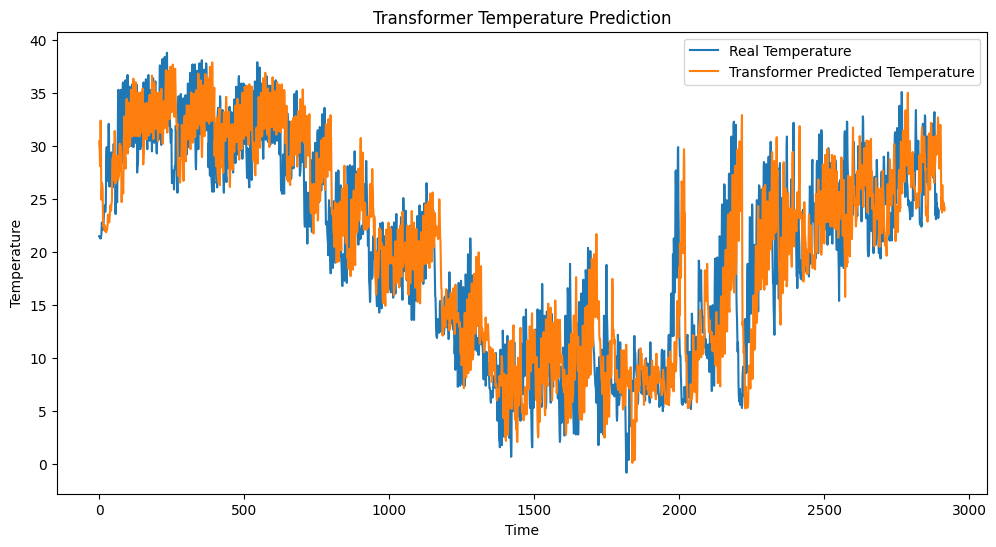

Transformer Relative Percentage Error (RPE): 35.24%


In [24]:
# 可视化
plt.figure(figsize=(12, 6))
plt.plot(transformer_real_values, label='Real Temperature')
plt.plot(transformer_predicted_values, label='Transformer Predicted Temperature')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Transformer Temperature Prediction')
plt.legend()
plt.show()

# 误差
min_length = min(len(transformer_predicted_values), len(transformer_real_values))
transformer_predicted_values = transformer_predicted_values[:min_length]
transformer_real_values = transformer_real_values[:min_length]
transformer_rpe = np.mean(np.abs((transformer_predicted_values - transformer_real_values) / transformer_real_values)) * 100
print("Transformer Relative Percentage Error (RPE): {:.2f}%".format(transformer_rpe))

In [25]:
def transformer_predict_future_days(model, data, seq_length, predict_days, device, scaler):
    """
    递归预测未来多天的气温（Transformer版）
    :param model: 已训练好的Transformer模型
    :param data: 已归一化的历史数据（二维数组）
    :param seq_length: 输入序列长度
    :param predict_days: 需要预测的天数
    :param device: 设备
    :param scaler: 用于反归一化
    :return: 预测的未来气温（已反归一化）
    """
    model.eval()
    input_seq = data[-seq_length:].copy()
    predictions = []
    with torch.no_grad():
        for _ in range(predict_days):
            inp = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).to(device)
            out = model(inp)
            pred_t = out.item()
            # 构造下一个输入（Tn、Tx用前一天的值）
            next_input = np.array([pred_t, input_seq[-1][1], input_seq[-1][2]])
            input_seq = np.vstack([input_seq[1:], next_input])
            predictions.append(next_input)
    predictions = np.array(predictions)
    predictions_inv = scaler.inverse_transform(predictions)[:, 0]
    return predictions_inv

# 用法示例（预测未来7天）：
future_days = 7
transformer_future_predictions = transformer_predict_future_days(
    transformer_model, tempure_data_scaled, seq_length, future_days, device, scaler)
print("Transformer未来7天气温预测：", transformer_future_predictions)

Transformer未来7天气温预测： [24.80605165 25.56591378 25.96563829 26.12505932 26.11812876 26.13701991
 26.24954493]
